<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/HW2_part_1_transfer_learning_nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler

# Homework 2, part 1

## transfer learning
1. below you will find the dataset object for the galaxy dataset from homework 1, except that now it outputs a 69x69 image (no flattening), and the single grayscale channel is repeated 3 times to give a 3x69x69 image

2. load a pre-trained network from pytorchs selection https://pytorch.org/docs/stable/torchvision/models.html

3. create a network to classify the galaxy image dataset with some parts from the pretrained network

4. train the new network

5. when you reach over 75% accuracy on the validation dataset, submit your trained model (state_dict and source code)

6. double check that if you train the same model without the pre-trained weights, it will perform worse (no need to submit this model) 

In [2]:
from google.colab import files
files.upload()

Saving Dataset.zip to Dataset.zip


In [3]:
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/validation/class3_1739.png  
  inflating: Dataset/validation/class2_279.png  
  inflating: Dataset/validation/class2_4655.png  
  inflating: Dataset/validation/class0_2288.png  
  inflating: Dataset/validation/class0_4821.png  
  inflating: Dataset/validation/class0_1781.png  
  inflating: Dataset/validation/class3_3890.png  
  inflating: Dataset/validation/class1_3828.png  
  inflating: Dataset/validation/class2_4899.png  
  inflating: Dataset/validation/class2_3648.png  
  inflating: Dataset/validation/class2_4127.png  
  inflating: Dataset/validation/class1_5.png  
  inflating: Dataset/validation/class4_2725.png  
  inflating: Dataset/validation/class4_2043.png  
  inflating: Dataset/validation/class0_1965.png  
  inflating: Dataset/validation/class2_2218.png  
  inflating: Dataset/validation/class2_245.png  
  inflating: Dataset/validation/class2_3106.png  
  inflating: Dataset/validation/class1_392.png  
  inf

In [111]:
path_to_training_data = '/content/Dataset/train/'
path_to_validation_data = '/content/Dataset/validation/'
print(path_to_training_data)

/content/Dataset/train/


In [0]:
import glob
from PIL import Image
from PIL import ImageFilter
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10,transform=False):
        
        self.mean = mean
        self.std = std
        
        self.do_transform = transform
        self.transform = transforms.RandomRotation(180)
        
        self.filelist = glob.glob(path+'/*.png')
        
        self.labels = np.zeros(len(self.filelist))
        
        for class_i in range(n_classes):
            self.labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        self.labels = torch.LongTensor(self.labels)
        
        
    def __len__(self):
       
        return len(self.filelist)

    def __getitem__(self, idx):
        
        img = Image.open(self.filelist[idx])
    
        if self.do_transform:
            
            img = self.transform(img)
        
        
        x = transforms.ToTensor()(img)
        
        x = (x-self.mean)/self.std
        
        x = x.repeat(3,1,1)
        
        
        class_label = self.labels[idx]
        
        return x, class_label

In [141]:
training_ds = CustomDataset(path_to_training_data,transform=False)
validation_ds = CustomDataset(path_to_validation_data,transform=False)
training_dataloader = DataLoader(training_ds,batch_size=120)
print(len(training_dataloader))
valid_dataloader = DataLoader(validation_ds,batch_size=120)
print(len(valid_dataloader))

84
42


In [0]:
x,y = training_ds[553]

In [143]:
x.shape

torch.Size([3, 69, 69])

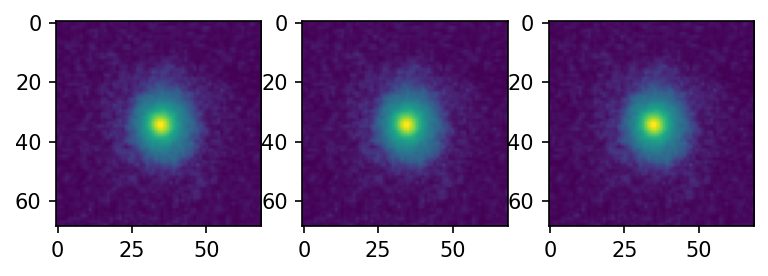

In [144]:
fig,ax = plt.subplots(1,3,figsize=(6,2),dpi=150)

for i in range(3):
    ax[i].imshow(x[i])

In [0]:
import torchvision.models as models


vgg11 = models.vgg16(pretrained=True)
#vgg11 = models.vgg11(pretrained=False)

In [118]:
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
import torch.cuda
if torch.cuda.is_available():
    vgg11.cuda()

In [0]:
class ImageClassifier(nn.Module):

    def __init__(self):
        super(ImageClassifier, self).__init__()
        
        #you can take all of the conv layers before the max pooling,
        self.features = vgg11.features
        self.parameters = vgg11.parameters
        self.avgpool = vgg11.avgpool
        self.classifier = vgg11.classifier
        index=0
        for param in self.parameters():
          if index==28:
            param.require_grad = True
          else:
            param.require_grad = False
          index=index+1
        self.features[28] = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #or you can take a subset of them
        #self.conv1 = vgg11.features[0]
        #self.conv2 = vgg11.features[3]
        #self.conv3 = vgg11.features[4]
        
        #if you want to use subsets of a sequential model:
        #self.part1 = nn.Sequential(*[vgg11.features[i] for i in range(16)]).
        temp0 = self.classifier[0].in_features 
        self.classifier[0] = nn.Linear(temp0,6272)
        self.classifier[3] = nn.Linear(6272,1568)
        self.classifier[6] = nn.Linear(1568,10)

    def forward(self, x):
      x = self.features(x)
      x = self.avgpool(x)
      x = torch.flatten(x,1)
      x = self.classifier(x)
      return x

In [0]:
img_class = ImageClassifier()
import torch.cuda
if torch.cuda.is_available():
    img_class.cuda()

In [0]:
training_ds = CustomDataset(path_to_training_data,transform=False)
validation_ds = CustomDataset(path_to_validation_data)

training_tensor = torch.stack([training_ds[i][0] for i in range(len(training_ds)) ])
training_tensor = training_tensor.cuda()
training_labels = training_ds.labels
training_labels = training_labels.cuda()

validation_tensor = torch.stack([validation_ds[i][0] for i in range(len(validation_ds)) ])
validation_tensor = validation_tensor.cuda()
validation_labels = validation_ds.labels
training_labels = training_labels.cuda()

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def dataset_accuracy(tensor_dataset,targets,net,loss_func):   #input tensor data set and target will be both in cuda device and are tensors , later output and targets are chnaged to numpy for accuracy calculation

    net.eval()
    output = net(tensor_dataset)
    loss = loss_func(output,targets)
    output = output.cpu().data.numpy()
    targets = targets.cpu().data.numpy()
    prediction = np.argmax(output,axis=1)
    n_correct = len(np.where(targets==prediction)[0])
    n_total = len(targets)
    return n_correct/n_total, loss.item()

In [0]:
dataset_accuracy(validation_tensor,validation_labels,img_class,loss_func)

In [0]:
import torch.optim as optim

optimizer = optim.SGD(img_class.parameters(), lr=0.01) 

In [131]:
from tqdm.notebook import tqdm

n_epochs = 25


loss_vs_epoch = []
accuracy_vs_epoch = []

for epoch in tqdm( range(n_epochs) ):
  print(epoch)
  training_loss = 0
  validation_loss =0
  training_accuracy = 0
  validation_accuracy = 0
  img_class.train()
  for x,y in training_dataloader:
    if torch.cuda.is_available():
      x,y = x.cuda(),y.cuda()
      #clear the grade of all optimzed variables 
      optimizer.zero_grad()
      output = img_class(x)
      #calculate the loss 
      loss = loss_func(output,y)
      loss.backward()
      optimizer.step()
      training_loss += loss.item() * x.size(0)
      accuracy,loss = dataset_accuracy(x,y,img_class,loss_func)
      print("training")
      print("loss is %f"%loss)
      print("accuracy is %f"%accuracy)
      training_accuracy += accuracy
    
  img_class.eval()
  for x,y in valid_dataloader:
    if torch.cuda.is_available():
      x,y = x.cuda(),y.cuda()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = img_class(x)   # calculate the loss
      loss = loss_func(output,y) # update running validation loss 
      validation_loss += loss.item() * x.size(0)
      accuracy,loss = dataset_accuracy(x,y,img_class,loss_func)
      print("validation")
      print("loss is %f"%loss)
      print("accuracy is %f"%accuracy)
      validation_accuracy += accuracy

  loss_vs_epoch.append([training_loss/len(training_ds), validation_loss/len(validation_ds)])
  accuracy_vs_epoch.append([(training_accuracy/len(training_dataloader))*100,(validation_accuracy/len(valid_dataloader))*100])
  

Streaming output truncated to the last 5000 lines.
loss is 0.517228
accuracy is 0.808333
validation
loss is 0.516304
accuracy is 0.808333
validation
loss is 0.647655
accuracy is 0.800000
validation
loss is 0.495886
accuracy is 0.825000
validation
loss is 0.480980
accuracy is 0.833333
validation
loss is 0.541631
accuracy is 0.791667
validation
loss is 0.534555
accuracy is 0.816667
validation
loss is 0.393467
accuracy is 0.883333
validation
loss is 0.558708
accuracy is 0.816667
validation
loss is 0.472437
accuracy is 0.800000
validation
loss is 0.474883
accuracy is 0.825000
validation
loss is 0.395833
accuracy is 0.841667
validation
loss is 0.588445
accuracy is 0.766667
validation
loss is 0.569641
accuracy is 0.816667
validation
loss is 0.491091
accuracy is 0.841667
validation
loss is 0.349027
accuracy is 0.916667
validation
loss is 0.514054
accuracy is 0.841667
validation
loss is 0.456139
accuracy is 0.833333
validation
loss is 0.636586
accuracy is 0.791667
validation
loss is 0.533906
a

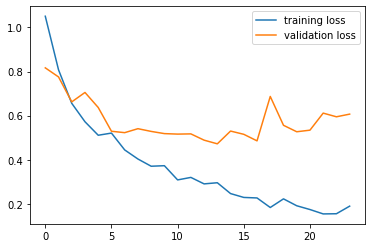

In [132]:
loss_vs_epoch = np.array(loss_vs_epoch)

plt.plot(loss_vs_epoch[:,0][1:],label='training loss')
plt.plot(loss_vs_epoch[:,1][1:],label='validation loss')

plt.legend()


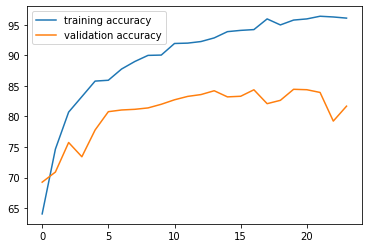

In [133]:
accuracy_vs_epoch = np.array(accuracy_vs_epoch)

plt.plot(accuracy_vs_epoch[:,0][1:],label='training accuracy')
plt.plot(accuracy_vs_epoch[:,1][1:],label='validation accuracy')

plt.legend()

In [74]:
img_class

ImageClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [0]:
torch.save(img_class.state_dict(), '/content/HW2_model.pt')